In [82]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen, HTTPError, URLError
from urllib.parse import urlparse
import re
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import random






%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [61]:
twt_data = pd.read_csv('../../../DataSets/twt_train.csv')
twt_data_with_links_saved = pd.read_csv('../../../DataSets/twt_with_links.csv')

ParserError: Error tokenizing data. C error: out of memory

In [ ]:
twt_data

In [ ]:
twt_data.describe()

In [ ]:
twt_data.info()

In [ ]:
def obtain_link(twt):
    url = re.search("(?P<url>https?://[^\s]+)", twt)
    return url.group("url") if url else np.NaN  

In [ ]:
twt_data['link'] = twt_data['text'].map(obtain_link)
twt_data

In [ ]:
twt_data.info()

In [ ]:
def isShorted(link):
    if link != link: return np.NaN 
    return 't.co' in str(link)

In [ ]:
twt_data['link_shorted'] = twt_data['link'].map(isShorted)


In [ ]:
twt_data

In [ ]:
twt_data_with_links = twt_data.dropna(subset=['link'])
twt_data_with_links

In [ ]:
twt_data_with_links = twt_data_with_links[twt_data_with_links['link_shorted']]
twt_data_with_links

In [ ]:
twt_data_with_links.info()

In [ ]:
twt_data_with_links['real_link'] = 'np.NaN'
twt_data_with_links['error'] = 'np.NaN'
twt_data_with_links['page'] = 'np.NaN'
twt_data_with_links = twt_data_with_links.reset_index()
twt_data_with_links.info()

In [ ]:
def obtain_real_link(index, url):
    try:
        with urlopen(url, timeout = 20) as response:
            actual_url = response.geturl()
            error = np.NaN
            page = response.read()
    except HTTPError as e:
        actual_url = e.url
        error = e
        page = np.NaN
    except URLError as e:
        actual_url = url
        error = e
        page = np.NaN
    except:
        actual_url = url
        error = 'OTHER_ERROR'
        page = np.NaN
    return (index, actual_url, error, page)

In [ ]:
def doWork(row):
    return obtain_real_link(row[0], row[1]['link'])

In [ ]:
twt_data_with_links_saved

In [ ]:
twt_data_with_links.head()

In [ ]:
twt_data_with_links.info()

In [ ]:
twt_data_with_links['site'] = twt_data_with_links['real_link'].map(lambda x: urlparse(x).netloc)
twt_data_with_links

In [ ]:
twt_data_with_links['site'].value_counts()

In [ ]:
twt_data_with_links.loc[twt_data_with_links['error'] != twt_data_with_links['error'], 'site'].value_counts()

In [ ]:
twt_data_with_links['target'].value_counts()

In [ ]:
twt_data_with_links.loc[twt_data_with_links['error'] != twt_data_with_links['error'], 'target'].value_counts()

In [3]:
twt_data_with_links_saved = twt_data_with_links_saved.loc[twt_data_with_links_saved['error'] != twt_data_with_links_saved['error']]
twt_data_with_links_saved

,Unnamed: 0,id,keyword,location,text,target,link,link_shorted,real_link,error,page,error_code
1,32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,http://t.co/YAo1e0xngw,True,https://twitter.com/Valis_Ablaze/status/629274...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan
3,35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,http://t.co/qqsmshaJ3N,True,https://twitter.com/AnyOtherAnnaK/status/62919...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan
5,38,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,http://t.co/wDUEaj8Q4J,True,https://www.youtube.com/watch?v=yG08hLEWzyM,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan
6,40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,http://t.co/rOI2NSmEJJ,True,https://www.freewebcamsex.me/2015-02-02-taking...,NaN,b'\r\n<!DOCTYPE html><html><head><title>Hot Ch...,nan
7,44,64,ablaze,NaN,I wanted to set Chicago ablaze with my preachi...,0,http://t.co/o9qknbfOFX,True,https://twitter.com/RevDominic/status/62927230...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan
...,...,...,...,...,...,...,...,...,...,...,...,...
3960,7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1,http://t.co/5ueCmcv2Pk,True,https://www.latimes.com/local/lanow/la-me-ln-r...,NaN,"b'<!DOCTYPE html>\n<html class=""ArticlePage"" l...",nan
3962,7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,http://t.co/EYSVvzA7Qm,True,https://www.youtube.com/watch?v=yG08hLEWzyM&3,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan
3963,7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,http://t.co/nF4IculOje,True,https://www.reuters.com/article/us-saudi-secur...,NaN,b'<!--[if !IE]> This has been served from cach...,nan
3965,7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,http://t.co/STfMbbZFB5,True,https://gizmodo.com/two-giant-cranes-holding-a...,NaN,"b'<!DOCTYPE html><html lang=""en-us"" data-react...",nan


In [4]:
def get_the_header(page):
    soup = BeautifulSoup(page, "lxml")
    header = str(soup.h1.string) if soup.h1 else ''
    soup.decompose()
    return header

In [5]:
twt_data_with_links_saved['header'] = twt_data_with_links_saved['page'].map(get_the_header)
twt_data_with_links_saved

,Unnamed: 0,id,keyword,location,text,target,link,link_shorted,real_link,error,page,error_code,header
1,32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,http://t.co/YAo1e0xngw,True,https://twitter.com/Valis_Ablaze/status/629274...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,None
3,35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,http://t.co/qqsmshaJ3N,True,https://twitter.com/AnyOtherAnnaK/status/62919...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,None
5,38,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,http://t.co/wDUEaj8Q4J,True,https://www.youtube.com/watch?v=yG08hLEWzyM,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan,\n This video is unavailable.\n\n...
6,40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,http://t.co/rOI2NSmEJJ,True,https://www.freewebcamsex.me/2015-02-02-taking...,NaN,b'\r\n<!DOCTYPE html><html><head><title>Hot Ch...,nan,Real Webcam Babes Performing in Hot Live Cam S...
7,44,64,ablaze,NaN,I wanted to set Chicago ablaze with my preachi...,0,http://t.co/o9qknbfOFX,True,https://twitter.com/RevDominic/status/62927230...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3960,7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1,http://t.co/5ueCmcv2Pk,True,https://www.latimes.com/local/lanow/la-me-ln-r...,NaN,"b'<!DOCTYPE html>\n<html class=""ArticlePage"" l...",nan,\n Refugio oil spill may have been cost...
3962,7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,http://t.co/EYSVvzA7Qm,True,https://www.youtube.com/watch?v=yG08hLEWzyM&3,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan,\n This video is unavailable.\n\n...
3963,7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,http://t.co/nF4IculOje,True,https://www.reuters.com/article/us-saudi-secur...,NaN,b'<!--[if !IE]> This has been served from cach...,nan,Suicide bomber kills 15 in Saudi security site...
3965,7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,http://t.co/STfMbbZFB5,True,https://gizmodo.com/two-giant-cranes-holding-a...,NaN,"b'<!DOCTYPE html><html lang=""en-us"" data-react...",nan,Two giant cranes holding a bridge collapse int...


In [ ]:
twt_data_with_links_saved.to_csv('../../../DataSets/twt_with_header.csv')

In [17]:
twt_data_with_links_saved = twt_data_with_links_saved.loc[twt_data_with_links_saved["header"] != 'None']
twt_data_with_links_saved = twt_data_with_links_saved.loc[twt_data_with_links_saved["header"] != '']
twt_data_with_links_saved

In [36]:
#repeticion_de_palabras
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].str.lower().str.strip() #transformo todas las palabras a minuscula
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda x: re.sub(r'[^\w]', ' ', x)) #quito todos los caracteres no alfanumericos
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda x: re.sub(r'_', ' ', x))
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda x: re.sub(r'[0-9]',' ', x)) #quito los caracteres numericos
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda s: re.sub(r'\b\w{1}\b', '', s)) #quito las letras sueltas
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda x: re.sub(' +',' ', x)) #quito los espacios de mas
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda s: re.sub(r'\b\w{1,2}\b', '', s)) #quito las palabras cortas


In [37]:
twt_data_with_links_saved['header_splited'] = twt_data_with_links_saved['header'].str.split(' ')
twt_data_with_links_saved

,id,keyword,location,text,target,link,link_shorted,real_link,error,page,error_code,header,header_splited
5,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,http://t.co/wDUEaj8Q4J,True,https://www.youtube.com/watch?v=yG08hLEWzyM,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan,this video unavailable,"[this, video, , unavailable]"
6,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,http://t.co/rOI2NSmEJJ,True,https://www.freewebcamsex.me/2015-02-02-taking...,NaN,b'\r\n<!DOCTYPE html><html><head><title>Hot Ch...,nan,real webcam babes performing hot live cam shows,"[real, webcam, babes, performing, , hot, live,..."
9,66,ablaze,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfire...,1,http://t.co/vl5TBR3wbr,True,https://mashable.com/2015/08/04/how-the-west-w...,NaN,b'<!DOCTYPE html>\n<html data-env=\'production...,nan,how the west was burned thousands wildfires a...,"[how, the, west, was, burned, thousands, , wil..."
10,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,http://t.co/rOI2NSmEJJ,True,https://www.freewebcamsex.me/2015-02-02-taking...,NaN,b'\r\n<!DOCTYPE html><html><head><title>Hot Ch...,nan,real webcam babes performing hot live cam shows,"[real, webcam, babes, performing, , hot, live,..."
11,73,ablaze,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ab...,1,http://t.co/gWNRhMSO8k,True,https://chroniclet.com/?utm_source=twitterfeed...,NaN,"b'\r\n\r\n<!DOCTYPE html>\r\n<html id=""ctl00_m...",nan,elyria and lorain county newspaper title,"[elyria, and, lorain, county, newspaper, title]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,10844,NaN,NaN,SEVERE WEATHER BULLETIN No. 5 FOR: TYPHOON ÛÏ...,1,http://t.co/tHhjJw51PE,True,https://www.facebook.com/PAGASA.DOST.GOV.PH/po...,NaN,"b'<!DOCTYPE html>\n<html lang=""en"" id=""faceboo...",nan,facebook,[facebook]
3960,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1,http://t.co/5ueCmcv2Pk,True,https://www.latimes.com/local/lanow/la-me-ln-r...,NaN,"b'<!DOCTYPE html>\n<html class=""ArticlePage"" l...",nan,refugio oil spill may have been costlier bigge...,"[refugio, oil, spill, may, have, been, costlie..."
3962,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,http://t.co/EYSVvzA7Qm,True,https://www.youtube.com/watch?v=yG08hLEWzyM&3,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan,this video unavailable,"[this, video, , unavailable]"
3963,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,http://t.co/nF4IculOje,True,https://www.reuters.com/article/us-saudi-secur...,NaN,b'<!--[if !IE]> This has been served from cach...,nan,suicide bomber kills saudi security site mosque,"[suicide, bomber, kills, , saudi, security, si..."


In [38]:
list_stopwords = ["the","and","you","for","that","with","this","from","are","have","was","like","but","just","not","your",\
                 "all","after","will","can","has","when","they","get","new","now","what","amp","","http","https","out",\
                 "more","about","how","there","don","over","into","than","would","been","her","who","were","some","still",\
                 "his","back","why","them","got","know","had","see","going","our","htt","via","nws","wait",\
                 "hwy","top","both","hah","haha","getting","far","near", "video", "unavailable", "is"]
def count_words(word, count):
    if(word in list_stopwords):
        return
    if (word in count):
        count[word] = count[word] + 1
        return
    count[word] = 1
        

In [39]:
total_word_count = {}
twt_data_with_links_saved['header_splited'].map(
    lambda x: [count_words(word, total_word_count) for word in x]
)
total_word_count

{'real': 6,
 'webcam': 2,
 'babes': 2,
 'performing': 2,
 'hot': 4,
 'live': 5,
 'cam': 2,
 'shows': 4,
 'west': 7,
 'burned': 4,
 'thousands': 5,
 'wildfires': 5,
 'ablaze': 2,
 'california': 36,
 'alone': 2,
 'elyria': 1,
 'lorain': 1,
 'county': 7,
 'newspaper': 1,
 'title': 3,
 'facebook': 63,
 'san': 1,
 'francisco': 1,
 'traffic': 5,
 'report': 2,
 'personal': 1,
 'injury': 3,
 'lawyer': 1,
 'sleep': 1,
 'blog': 8,
 'big': 3,
 'rig': 1,
 'overturns': 2,
 'fort': 2,
 'worth': 1,
 'interstate': 1,
 'columbus': 2,
 'aashiqui': 1,
 'actress': 1,
 'anu': 1,
 'aggarwal': 1,
 'fatal': 3,
 'accident': 2,
 'icemoon': 7,
 'aftershock': 8,
 'these': 3,
 'five': 4,
 'minute': 1,
 'daily': 1,
 'habits': 1,
 'seriously': 1,
 'improve': 1,
 'life': 6,
 'protect': 1,
 'yourself': 1,
 'profit': 1,
 'next': 2,
 'global': 3,
 'financial': 3,
 'meltdown': 2,
 'cindy': 1,
 'spitzer': 1,
 'david': 2,
 'wiedemer': 2,
 'robert': 1,
 'hardcover': 1,
 'reunion': 11,
 'island': 11,
 'wing': 11,
 'debris': 

In [40]:
disaster_word_count = {}
twt_data_with_links_saved.loc[twt_data_with_links_saved['target'] == 1,'header_splited'].map(
    lambda x: [count_words(word, disaster_word_count) for word in x] if (x != None) else None
)
disaster_word_count

{'west': 6,
 'burned': 3,
 'thousands': 4,
 'wildfires': 5,
 'ablaze': 2,
 'california': 34,
 'alone': 2,
 'elyria': 1,
 'lorain': 1,
 'county': 6,
 'newspaper': 1,
 'title': 3,
 'san': 1,
 'francisco': 1,
 'traffic': 5,
 'report': 2,
 'facebook': 26,
 'big': 2,
 'rig': 1,
 'overturns': 2,
 'fort': 1,
 'worth': 1,
 'interstate': 1,
 'columbus': 1,
 'aashiqui': 1,
 'actress': 1,
 'anu': 1,
 'aggarwal': 1,
 'fatal': 3,
 'accident': 2,
 'reunion': 11,
 'island': 11,
 'wing': 11,
 'debris': 16,
 'flight': 10,
 'malaysia': 9,
 'prime': 7,
 'minister': 8,
 'says': 25,
 'longer': 15,
 'available': 5,
 'because': 5,
 'youtube': 5,
 'account': 8,
 'associated': 5,
 'terminated': 5,
 'shropshire': 1,
 'star': 2,
 'twelve': 1,
 'feared': 5,
 'killed': 2,
 'pakistani': 2,
 'air': 2,
 'ambulance': 1,
 'helicopter': 4,
 'crash': 9,
 'game': 3,
 'cheats': 2,
 'tools': 2,
 'generators': 2,
 'online': 3,
 'important': 6,
 'mourning': 4,
 'notices': 4,
 'stabbing': 4,
 'arson': 11,
 'victims': 5,
 'stir

In [41]:
normal_word_count = {}
twt_data_with_links_saved.loc[twt_data_with_links_saved['target'] == 0,'header_splited'].map(
    lambda x: [count_words(word, normal_word_count) for word in x] if (x != None) else None
)
normal_word_count

{'real': 4,
 'webcam': 2,
 'babes': 2,
 'performing': 2,
 'hot': 4,
 'live': 4,
 'cam': 2,
 'shows': 2,
 'facebook': 37,
 'personal': 1,
 'injury': 3,
 'lawyer': 1,
 'sleep': 1,
 'blog': 6,
 'icemoon': 7,
 'aftershock': 8,
 'these': 1,
 'five': 2,
 'minute': 1,
 'daily': 1,
 'habits': 1,
 'seriously': 1,
 'improve': 1,
 'life': 3,
 'protect': 1,
 'yourself': 1,
 'profit': 1,
 'next': 2,
 'global': 2,
 'financial': 3,
 'meltdown': 2,
 'cindy': 1,
 'spitzer': 1,
 'david': 2,
 'wiedemer': 2,
 'robert': 1,
 'hardcover': 1,
 'emts': 1,
 'petition': 6,
 'per': 1,
 'hour': 1,
 'minimum': 1,
 'wage': 1,
 'content': 15,
 'warning': 7,
 'armageddon': 2,
 'payamps': 1,
 'secret': 2,
 'penis': 1,
 'time': 4,
 'infantry': 1,
 'mens': 1,
 'youth': 1,
 'military': 2,
 'army': 1,
 'sport': 1,
 'quartz': 1,
 'analog': 1,
 'wrist': 1,
 'watch': 1,
 'blue': 3,
 'nylon': 1,
 'strap': 1,
 'blu': 1,
 'cuenta': 32,
 'suspendida': 31,
 'mourning': 1,
 'notices': 1,
 'stabbing': 1,
 'arson': 1,
 'victims': 1,


In [42]:
{k: v for k, v in sorted(normal_word_count.items(), key=lambda item: item[1], reverse = True)}


{'facebook': 37,
 'cuenta': 32,
 'suspendida': 31,
 'news': 28,
 'city': 26,
 'guide': 26,
 'celebrity': 25,
 'content': 15,
 'emergency': 14,
 'longer': 10,
 'reddit': 9,
 'protection': 9,
 'aftershock': 8,
 'fedex': 8,
 'transport': 8,
 'bioterror': 8,
 'germs': 8,
 'wake': 8,
 'anthrax': 8,
 'lab': 8,
 'mishaps': 8,
 'police': 8,
 'under': 8,
 'icemoon': 7,
 'warning': 7,
 'bolsos': 7,
 'carteras': 7,
 'para': 7,
 'mujer': 7,
 'quarantine': 7,
 'offensive': 7,
 'rules': 7,
 'blog': 6,
 'petition': 6,
 'plan': 6,
 'xbd': 6,
 'people': 6,
 'bloomberg': 6,
 'seeks': 6,
 'sinkhole': 6,
 'media': 5,
 'world': 5,
 'ban': 5,
 'summer': 5,
 'xbc': 5,
 'day': 5,
 'web': 5,
 'surfing': 5,
 'finally': 5,
 'panicking': 5,
 'cable': 5,
 'stretcher': 5,
 'texas': 5,
 'comment': 5,
 'changes': 5,
 'windstorm': 5,
 'insurer': 5,
 'real': 4,
 'hot': 4,
 'live': 4,
 'time': 4,
 'keep': 4,
 'bee': 4,
 'killing': 4,
 'pesticides': 4,
 'capture': 4,
 'australia': 4,
 'home': 4,
 'epic': 4,
 'food': 4,
 

In [43]:
{k: v for k, v in sorted(disaster_word_count.items(), key=lambda item: item[1], reverse = True)}


{'california': 34,
 'legionnaires': 30,
 'disease': 30,
 'outbreak': 30,
 'cue': 30,
 'hiroshima': 28,
 'oil': 28,
 'spill': 27,
 'facebook': 26,
 'atomic': 26,
 'families': 26,
 'says': 25,
 'may': 24,
 'sue': 24,
 'edinburgh': 24,
 'news': 22,
 'projected': 22,
 'refugio': 21,
 'costlier': 21,
 'bigger': 21,
 'bomb': 20,
 'mediterranean': 20,
 'suicide': 19,
 'years': 19,
 'city': 19,
 'two': 18,
 'water': 18,
 'debris': 16,
 'japan': 16,
 'fire': 16,
 'guide': 16,
 'longer': 15,
 'cuenta': 15,
 'train': 15,
 'celebrity': 15,
 'police': 14,
 'crisis': 14,
 'during': 14,
 'msf': 14,
 'picking': 14,
 'bodies': 14,
 'attack': 13,
 'collapse': 13,
 'storm': 13,
 'nuclear': 13,
 'memories': 13,
 'off': 12,
 'saudi': 12,
 'bombs': 12,
 'bomber': 12,
 'reunion': 11,
 'island': 11,
 'wing': 11,
 'arson': 11,
 'suspendida': 11,
 'lab': 11,
 'homes': 11,
 'food': 11,
 'missing': 11,
 'struggles': 11,
 'wartime': 11,
 'past': 11,
 'amid': 11,
 'flight': 10,
 'northern': 10,
 'fedex': 10,
 'tran

In [44]:
{k: v for k, v in sorted(total_word_count.items(), key=lambda item: item[1], reverse = True)}


{'facebook': 63,
 'news': 50,
 'cuenta': 47,
 'city': 45,
 'suspendida': 42,
 'guide': 42,
 'celebrity': 40,
 'california': 36,
 'legionnaires': 30,
 'disease': 30,
 'outbreak': 30,
 'cue': 30,
 'oil': 29,
 'hiroshima': 28,
 'may': 27,
 'spill': 27,
 'atomic': 26,
 'families': 26,
 'says': 25,
 'longer': 25,
 'sue': 24,
 'edinburgh': 24,
 'police': 22,
 'years': 22,
 'projected': 22,
 'refugio': 21,
 'costlier': 21,
 'bigger': 21,
 'two': 20,
 'bomb': 20,
 'mediterranean': 20,
 'fire': 19,
 'suicide': 19,
 'lab': 19,
 'fedex': 18,
 'transport': 18,
 'bioterror': 18,
 'germs': 18,
 'wake': 18,
 'anthrax': 18,
 'mishaps': 18,
 'emergency': 18,
 'water': 18,
 'content': 17,
 'during': 17,
 'debris': 16,
 'japan': 16,
 'collapse': 16,
 'nuclear': 16,
 'off': 15,
 'train': 15,
 'food': 15,
 'attack': 14,
 'crisis': 14,
 'msf': 14,
 'picking': 14,
 'bodies': 14,
 'first': 13,
 'storm': 13,
 'memories': 13,
 'arson': 12,
 'people': 12,
 'homes': 12,
 'under': 12,
 'saudi': 12,
 'bombs': 12,
 

In [60]:
twt_data.head()

NameError: name 'twt_data' is not defined

In [ ]:
twt_data['for_graphics'] = 1
grouped_twt = twt_data.groupby('target').sum().reset_index()
g = sns.barplot(x='target', y='for_graphics', data=grouped_twt)
for index, row in grouped_twt.iterrows():
    g.text(row.target, row.for_graphics, row.for_graphics, color='black', ha="center")
g.set_title("Cantidad de tweets segun su target", fontsize=16, pad=20)
g.set_xlabel("Target", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
def is_not_nan(value):
    return value == value

In [ ]:
twt_data['with_link'] = twt_data['link'].map(is_not_nan)
twt_data

In [ ]:
grouped_twt = twt_data.groupby('with_link').sum().reset_index()
g = sns.barplot(x='with_link', y='for_graphics', data=grouped_twt)
for index, row in grouped_twt.iterrows():
    g.text(row.name, row.for_graphics, row.for_graphics, color='black', ha="center")
g.set_title("Cantidad de tweets segun la existencia de links", fontsize=16, pad=20)
g.set_xlabel("Tiene link?", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
grouped_twt = twt_data.groupby(['target', 'with_link']).sum().reset_index()
g = sns.barplot(x='target', y='for_graphics', hue='with_link', data=grouped_twt)
g.set_title("Cantidad de tweets segun su target y si tiene link", fontsize=16, pad=20)
g.set_xlabel("Target", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
grouped_by_target_twt = twt_data.groupby(['target']).sum().reset_index()
grouped_by_links_twt = twt_data.groupby(['target', 'with_link']).sum().reset_index()


In [ ]:
grouped_by_target_twt

In [ ]:
grouped_by_links_twt

In [ ]:
grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == False, 'for_graphics'] = grouped_by_target_twt.loc[:, 'for_graphics']
grouped_by_links_twt

In [ ]:
grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == False, 'for_graphics'] = grouped_by_target_twt['for_graphics'].tolist()
grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == False, 'with_link'] = 'Total'
grouped_by_links_twt

In [ ]:
g = sns.barplot(x = 'target', y = 'for_graphics', data=grouped_by_links_twt, hue='with_link', dodge=False)
g.set_title("Cantidad de tweets segun la existencia de links", fontsize=16, pad=20)
g.set_xlabel("Tiene link?", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
g = sns.barplot(x = 'target', y = 'for_graphics', data=grouped_by_links_twt, hue='with_link')
g.set_title("Cantidad de tweets segun la existencia de links", fontsize=16, pad=20)
g.set_xlabel("Tiene link?", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
twt_with_link = grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == True]
g = sns.barplot(x = 'target', y = 'for_graphics', data=twt_with_link)
g.set_title("Cantidad de tweets que contienen link segun el target", fontsize=16, pad=20)
g.set_xlabel("Target", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)
for index, row in twt_with_link.iterrows():
    g.text(row.target, row.for_graphics, row.for_graphics, color='black', ha="center")

A continuacion trabajaremos exclusivamente con los twits que poseen links

In [ ]:
twt_data_with_links = twt_data_with_links.drop(columns=['Unnamed: 0'])
twt_data_with_links['for_graphics'] = 1
twt_data_with_links

In [ ]:
grouped_by_sites = twt_data_with_links.groupby('site').sum()
grouped_by_sites

In [ ]:
sites_top_20 = grouped_by_sites.sort_values('for_graphics', ascending=False).head(20).reset_index()
sites_top_20

In [ ]:
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

Dejaremos afuera el sition t.co y los que tienen como sitio twitter.com y error 

In [ ]:
def filter_twitter_error(row):
    return row.site != 't.co' and (row.site != 'twitter.com' or row.error != row.error)

In [ ]:
filter_list = []
for index, row in twt_data_with_links.iterrows():
    filter_list.append(filter_twitter_error(row))
twt_data_with_links.loc[filter_list]

In [ ]:
sites_top_20_filtered = twt_data_with_links.loc[filter_list].groupby('site').sum()\
    .sort_values('for_graphics', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20_filtered)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

In [ ]:
sites_top_20_filtered = twt_data_with_links.loc[filter_list].loc[twt_data_with_links['target']==1].groupby('site')\
    .sum().sort_values('for_graphics', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20_filtered)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

In [ ]:
sites_top_20_filtered = twt_data_with_links.loc[filter_list].loc[twt_data_with_links['target']==0].groupby('site')\
    .sum().sort_values('for_graphics', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20_filtered)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

A continuacion nos quedaremos solo con las lineas que no contienen errores ya que analizaremos las paginas

In [ ]:
twt_data_with_links

In [8]:
twt_data_with_links_saved.drop(columns=['Unnamed: 0'], inplace=True)
twt_data_with_links_saved

,id,keyword,location,text,target,link,link_shorted,real_link,error,page,error_code,header
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,http://t.co/YAo1e0xngw,True,https://twitter.com/Valis_Ablaze/status/629274...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,None
3,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,http://t.co/qqsmshaJ3N,True,https://twitter.com/AnyOtherAnnaK/status/62919...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,None
5,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,http://t.co/wDUEaj8Q4J,True,https://www.youtube.com/watch?v=yG08hLEWzyM,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan,\n This video is unavailable.\n\n...
6,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,http://t.co/rOI2NSmEJJ,True,https://www.freewebcamsex.me/2015-02-02-taking...,NaN,b'\r\n<!DOCTYPE html><html><head><title>Hot Ch...,nan,Real Webcam Babes Performing in Hot Live Cam S...
7,64,ablaze,NaN,I wanted to set Chicago ablaze with my preachi...,0,http://t.co/o9qknbfOFX,True,https://twitter.com/RevDominic/status/62927230...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,None
...,...,...,...,...,...,...,...,...,...,...,...,...
3960,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1,http://t.co/5ueCmcv2Pk,True,https://www.latimes.com/local/lanow/la-me-ln-r...,NaN,"b'<!DOCTYPE html>\n<html class=""ArticlePage"" l...",nan,\n Refugio oil spill may have been cost...
3962,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,http://t.co/EYSVvzA7Qm,True,https://www.youtube.com/watch?v=yG08hLEWzyM&3,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan,\n This video is unavailable.\n\n...
3963,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,http://t.co/nF4IculOje,True,https://www.reuters.com/article/us-saudi-secur...,NaN,b'<!--[if !IE]> This has been served from cach...,nan,Suicide bomber kills 15 in Saudi security site...
3965,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,http://t.co/STfMbbZFB5,True,https://gizmodo.com/two-giant-cranes-holding-a...,NaN,"b'<!DOCTYPE html><html lang=""en-us"" data-react...",nan,Two giant cranes holding a bridge collapse int...


In [53]:
total_header_words = pd.DataFrame(list(total_word_count.items()), index=range(len(total_word_count.items())),\
                                  columns=['word', 'count'])
disaster_header_words = pd.DataFrame(list(disaster_word_count.items()), index=range(len(disaster_word_count.items())),\
                                  columns=['word', 'count'])
normal_header_words = pd.DataFrame(list(normal_word_count.items()), index=range(len(normal_word_count.items())),\
                                  columns=['word', 'count'])
total_header_words

,word,count
0,real,6
1,webcam,2
2,babes,2
3,performing,2
4,hot,4
...,...,...
2322,paul,1
2323,weeks,1
2324,furious,1
2325,weren,1


In [54]:
disaster_header_words

,word,count
0,west,6
1,burned,3
2,thousands,4
3,wildfires,5
4,ablaze,2
...,...,...
1474,before,1
1475,mystery,1
1476,wrecked,1
1477,wants,1


In [55]:
normal_header_words

,word,count
0,real,4
1,webcam,2
2,babes,2
3,performing,2
4,hot,4
...,...,...
1233,continues,1
1234,spark,1
1235,protest,1
1236,raleigh,1


Text(0, 0.5, 'Sitios')

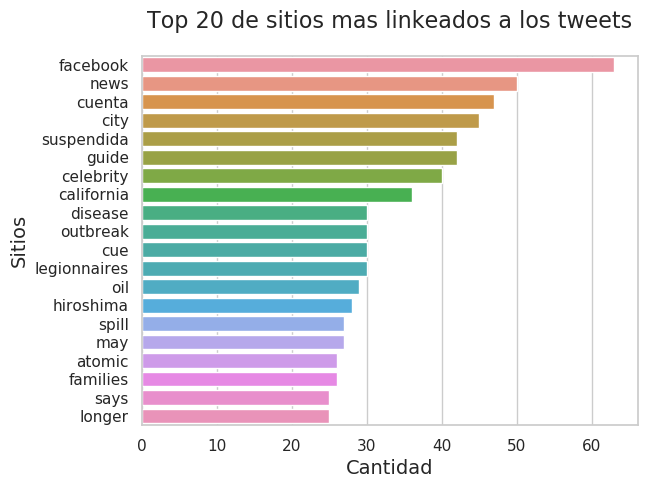

In [57]:
words_top_20 = total_header_words.sort_values('count', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'count', y = 'word', data=words_top_20)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

Text(0, 0.5, 'Sitios')

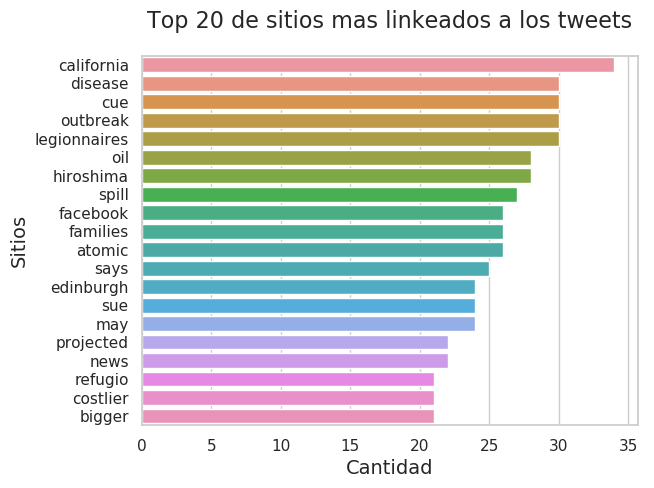

In [58]:
words_top_20 = disaster_header_words.sort_values('count', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'count', y = 'word', data=words_top_20)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

Text(0, 0.5, 'Sitios')

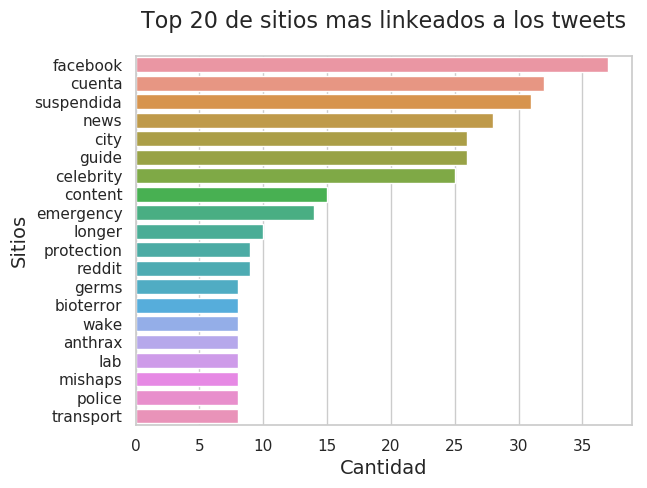

In [59]:
words_top_20 = normal_header_words.sort_values('count', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'count', y = 'word', data=words_top_20)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

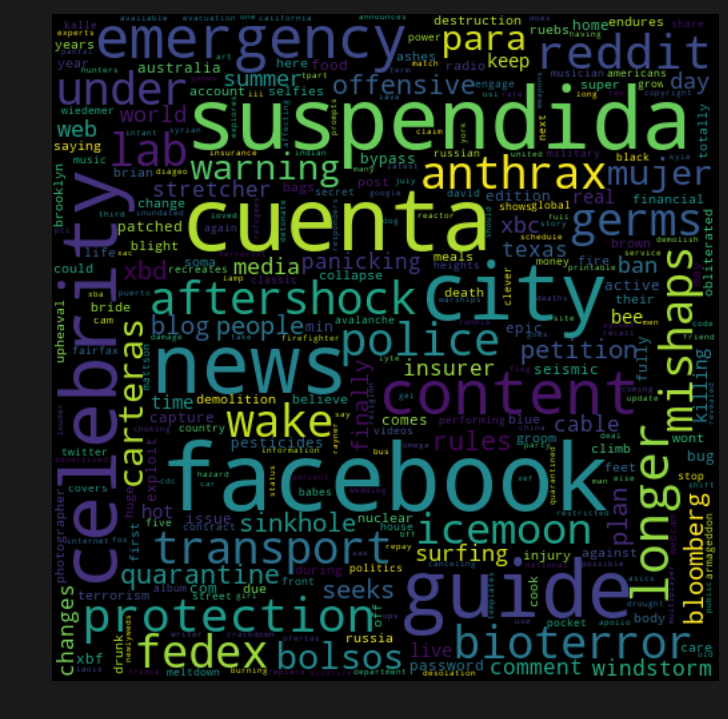

In [70]:
#palabras mas usadas en tweets no tienen que ver con desastres reales
wordcloud = WordCloud(width = 500, height = 500, min_font_size = 5, max_font_size = 70, max_words = 1000, 
                      background_color = 'black', stopwords = list_stopwords).generate_from_frequencies(normal_word_count)
fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

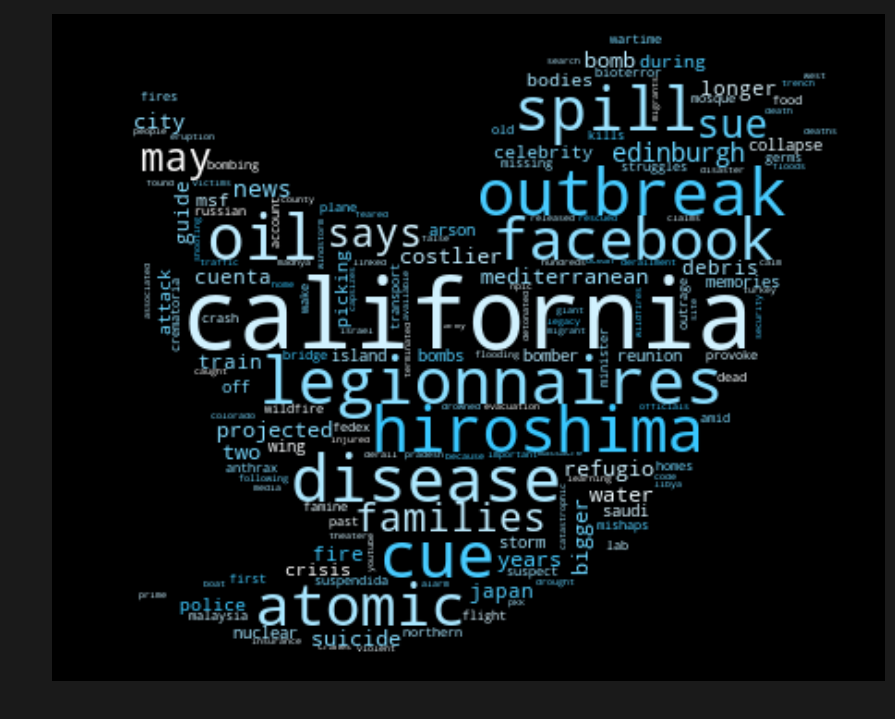

In [91]:
#palabras mas usadas en tweets no tienen que ver con desastres reales
mask = np.array(Image.open(('../../../DataSets/twitter.png')))
wordcloud = WordCloud(width = 500, height = 500, min_font_size = 5, max_font_size = 70, max_words = 1000, 
                      background_color = 'black', mask=mask, stopwords = list_stopwords).generate_from_frequencies(disaster_word_count)
fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k')
plt.imshow(wordcloud.recolor(color_func=twitter_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

A continuacion algunos histogramas

In [90]:
def twitter_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(197, 100%%, %d%%)" % random.randint(60, 100)